# Sarus Demo - Build a sklearn model on private census data

### Installing Sarus & loading Sarus version of my usual libraries

In [1]:
%%capture
!pip install sarus==0.4.2 sarus[sklearn] --pre -U 

In [2]:
# Just add "sarus." to the import lines for standard libraries
import sarus.pandas as pd 
from sarus.sklearn.preprocessing import LabelEncoder
from sarus.sklearn.model_selection import train_test_split
from sarus.sklearn.ensemble import RandomForestClassifier
from sarus.sklearn.metrics import accuracy_score

### Selecting protected data and exploring it

In [3]:
from sarus import Client

In [4]:
client = Client(url="https://admin.sarus.tech:5000", email="analyst@example.com") # Use your instance & credentials

Password: ········


In [5]:
client.list_datasets()

[<Sarus Dataset slugname=census id=29>,
 <Sarus Dataset slugname=london_bicycle_hires id=8>,
 <Sarus Dataset slugname=patient_data id=2>]

In [6]:
remote_dataset = client.dataset(slugname="census")

In [7]:
remote_dataset.tables()

[['census']]

In [8]:
df = remote_dataset.table(['census']).as_pandas()

In [9]:
df.head(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,46,Self-emp-not-inc,356393,Masters,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,75,United-States,<=50K
1,34,Self-emp-not-inc,28828,Bachelors,12,Married-civ-spouse,Exec-managerial,Husband,White,Female,0,0,63,United-States,>50K
2,21,Private,188496,Assoc-acdm,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,23188,0,67,India,>50K


In [10]:
print([col for col in df.columns])

['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


In [11]:
df.income.value_counts()/df.shape[0]

>50K     0.532907
<=50K    0.467093
Name: income, dtype: float64

In [12]:
type(df.income.value_counts()/df.shape[0])

sarus.pandas.dataframe.Series

### Preprocessing and modeling data remotely

In [13]:
# Handling missing values
df = df.fillna(0)

# Splitting into X,y
target_colname = 'income'
X = df.drop([target_colname], axis=1)
y = df[target_colname]

# Encoding X categorical variables
cat = pd.get_dummies(X.select_dtypes(["object"]), drop_first=True)
X = cat.join(X.select_dtypes(["float64", "float32", "int64", "bool"]))

# Splitting into train and test datasets
result = train_test_split(X, y, test_size=0.2)
X_train = result[0]
X_test = result[1]
y_train = result[2]
y_test = result[3]

# Encoding y
lbl = LabelEncoder()
lbl.fit(y)

y_train = lbl.transform(y_train)
y_test = lbl.transform(y_test)
y = lbl.transform(y)

In [14]:
X_train.head(3)

,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,...,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
286,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,34,308147,10,5007,0,46
4117,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,45,161763,11,67737,0,40
2265,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,42,348189,9,12148,0,43


In [15]:
type(X_train)

sarus.pandas.dataframe.DataFrame

In [16]:
# Check the evaluation policy of the object: 
# is it a DP estimate or a whitelisted result (ie executed on the real data)?
from sarus import eval_policy
eval_policy(y_train)

'DP estimate'

In [17]:
model = RandomForestClassifier()

fitted_model = model.fit(X=X_train, y=y_train)
y_pred = fitted_model.predict(X_test)

In [18]:
accuracy_score(y_pred, y_test)

0.895

In [19]:
eval_policy(fitted_model)

'Result of whitelisted operations'

In [20]:
eval_policy(accuracy_score(y_pred, y_test))

'Result of whitelisted operations'

### Under the hood
Below is the graph that is compiled by the Sarus SDK to analyze the requested sequence of operations, see if the analyst is autorized to run it on the remote data and compile an authorized alternative if not.

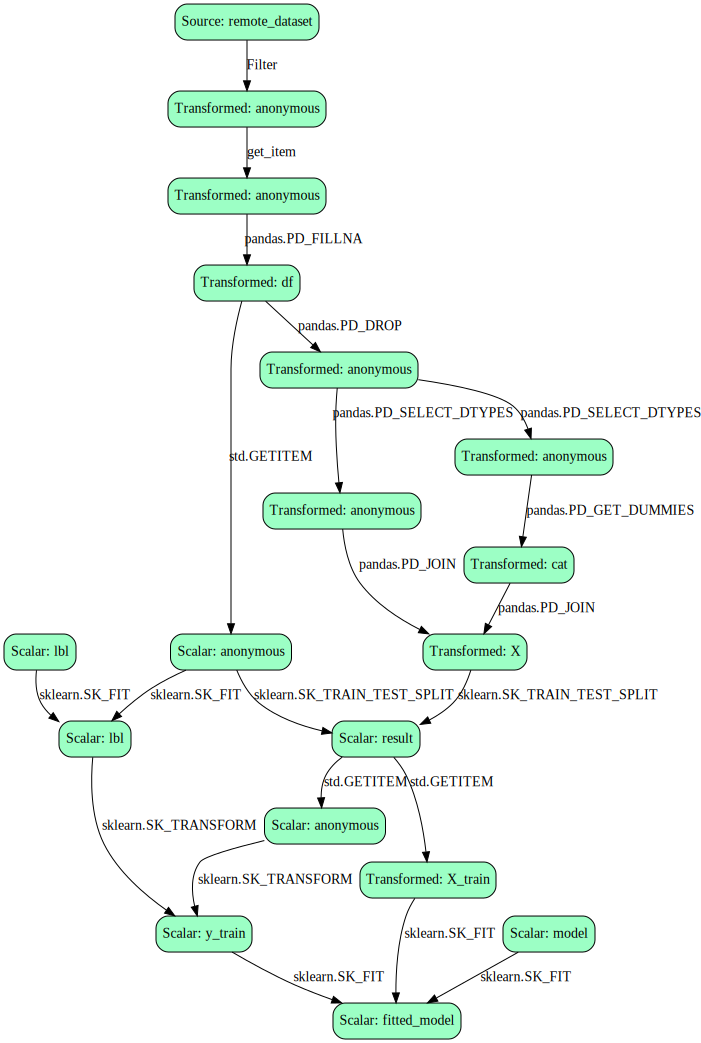

In [21]:
from graphviz import Source
from IPython.display import display, HTML
from sarus.typing import DataSpecVariant

def display_computation(value: str):
    display(HTML("<h3>Computation graph executed remotely on Sarus server</h3>"))
    display(Source(eval(value).dot(kind=DataSpecVariant.ALTERNATIVE, remote=True)))

display_computation('fitted_model')

### Running SQL queries

In [22]:
r = client.query("""SELECT education, AVG(age) AS avg_age FROM census
                 GROUP BY education ORDER BY avg_age DESC LIMIT 3""")
pd.DataFrame(r['result'], columns=r['columns'])

,education,avg_age
0,1st-4th,55.682595
1,7th-8th,50.682639
2,Doctorate,50.287146
